# Welcome to the matched filtering tutorial! 

### Installation 

Make sure you have PyCBC and some basic lalsuite tools installed.

**Only execute the below cell if you have not already installed `pycbc`**

*Note* –– if you were not able to install pycbc, or you got errors preventing your from importing pycbc, please upload this notebook to [google collaboratory](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true), where you can easily `pip install lalsuite pycbc` and run the entire notebook.

In [ ]:
# ! pip install lalsuite pycbc

<span style="color:gray">Jess notes: this notebook was made with a PyCBC 1.8.0 kernel. </span>

### Learning goals 

With this tutorial, you learn how to:

* Generate source waveforms detectable by LIGO, Virgo, KAGRA
* Use PyCBC to run a matched filter search on gravitational wave detector data 
* Estimate the significance of a trigger given a background distribution
* **Challenge**: Code up a trigger coincidence algorithm 

This tutorial borrows heavily from tutorials made for the [LIGO-Virgo Open Data Workshop](https://www.gw-openscience.org/static/workshop1/course.html) by Alex Nitz. You can find PyCBC documentation and additional examples [here](http://pycbc.org/pycbc/latest/html/py-modindex.html). 

Let's get started!

___

## Generate a gravitational wave signal waveform

We'll use a popular waveform approximant ([SOEBNRv4](https://arxiv.org/pdf/1611.03703.pdf)) to generate waveforms that would be detectable by LIGO, Virgo, or KAGRA. 

First we import the packages we'll need. 

In [42]:
from pycbc.waveform import get_td_waveform
import matplotlib.pyplot as plt

Let's see what these waveforms look like for different component masses. We'll assume the two compact object have masses equal to each other, and we'll set a lower frequency bound of 30 Hz (determined by the sensitivity of our detectors).

We can also set a time sample rate with `get_td_waveform`. Let's try a rate of 4096 Hz. 

Let's make a plot of the plus polarization (`hp`) to get a feel for what the waveforms look like.

*Hint* –– you may want to zoom in on the plot to see the waveforms in detail.

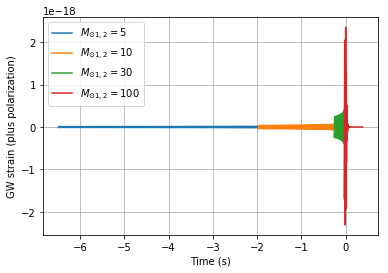

In [43]:
for m in [5, 10, 30, 100]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower=30)
    plt.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
plt.legend(loc='upper left')
plt.ylabel('GW strain (plus polarization)')
plt.grid()
plt.xlabel('Time (s)')
plt.show()

 Now let's see what happens if we decrease the lower frequency bound from 30 Hz to 15 Hz. 

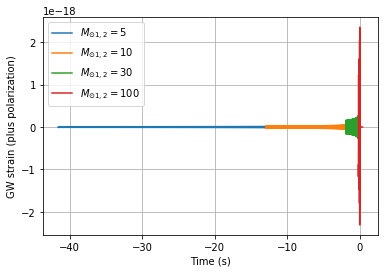

In [44]:
for m in [5, 10, 30, 100]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=m,
                         mass2=m,
                         delta_t=1.0/4096,
                         f_lower= # complete
    
    pylab.plot(hp.sample_times, hp, label='$M_{\odot 1,2}=%s$' % m)
pylab.legend(loc='upper left')
pylab.ylabel('GW strain (plus polarization)')
pylab.grid()
pylab.xlabel('Time (s)')
pylab.show()

---

### Exercise 1

What happens to the waveform when the total mass (let's say 20 M<sub>sol</sub>) stays the same, but the mass ratio between the component masses changes? 

Compare the waveforms for a m<sub>1</sub> = m<sub>2</sub> = 10 M<sub>sol</sub> system, a m<sub>1</sub> = 5 M<sub>sol</sub>, m<sub>2</sub> = 15 M<sub>sol</sub>, and  a m<sub>1</sub> = 2 M<sub>sol</sub>, m<sub>2</sub> = 18 M<sub>sol</sub> system. What do you notice? 



In [ ]:
# complete 

### Exercise 2 

How much longer (in signal duration) would LIGO and Virgo (and KAGRA) be able to detect a 1.4-1.4 M<sub>sol</sub> binary neutron star system if our detectors were sensitive down to 10 Hz instead of 30 Hz? ** Note you'll need to use a different waveform approximant here. Try TaylorF2.** 

<span style="color:gray">Jess notes: this would be a major benefit of next-generation ("3G") ground-based gravitational wave detectors.</span>

In [ ]:
# complete 

---

### Distance vs. signal amplitude

Let's see what happens when we scale the distance (in units of Megaparsecs) for a system with a total mass of 20 M<sub>sol</sub>. 

<span style="color:gray">Note: redshift effects are not included here.</span>

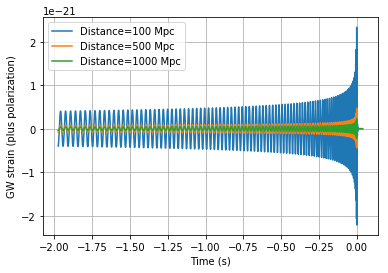

In [45]:
for d in [100, 500, 1000]:
    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=d)
    
    pylab.plot(hp.sample_times, hp, label='Distance=%s Mpc' % d)
pylab.grid()
pylab.xlabel('Time (s)')
pylab.ylabel('GW strain (plus polarization)')
pylab.legend(loc='upper left')
pylab.show()

---

## Run a matched filter search on gravitational wave detector data

PyCBC also maintains a catalog of open data as PyCBC time series objects, easy to manipulate with PyCBC tools. Let's try using that and importing the data around the first detection, GW150914. 


In [46]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass

merger = Merger("GW150914")

# Get the data from the Hanford detector
strain = merger.strain('H1')

### Data pre-conditioning 

Once we've imported the open data from this alternate source, the first thing we'll need to do is **pre-condition** the data. This serves a few purposes: 
* 1) reduces the dynamic range of the data
* 2) supresses high amplitudes at low frequencies, which can introduce numerical artifacts
* 3) if we don't need high frequency information, downsampling allows us to compute our matched filter result faster

Let's try highpassing above 15 Hz and downsampling to 2048 Hz, and we'll make a plot to see what the result looks like:

Text(0.5,0,'Time (s)')

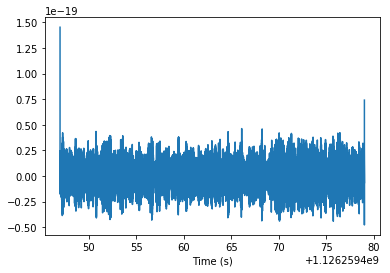

In [47]:
# Remove the low frequency content and downsample the data to 2048Hz
strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)

plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)')

Notice the large amplitude excursions in the data at the start and end of our data segment. This is **spectral leakage** caused by filters we applied to the boundaries ringing off the discontinuities where the data suddenly starts and ends (for a time up to the length of the filter).

To avoid this we should trim the ends of the data in all steps of our filtering. Let's try cropping a couple seconds off of either side. 

Text(0.5,0,'Time (s)')

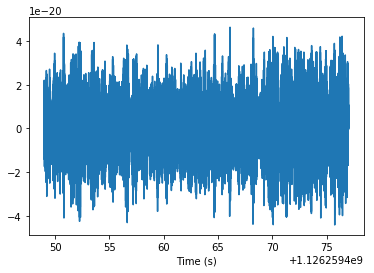

In [48]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(2, 2)

plt.plot(conditioned.sample_times, conditioned)
plt.xlabel('Time (s)')

That's better. 

### Calculating the spectral density of the data

Optimal matched filtering requires *whitening*; weighting the frequency components of the potential signal and data by the estimated noise amplitude.

Let's compute the power spectral density (PSD) of our conditioned data. 


In [56]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 * conditioned.sample_rate,
                                  low_frequency_cutoff=15)


----

### Define a signal model 

Recall that matched filtering is essentially integrating the inner product between your data and your signal model in frequency or time (after weighting frequencies correctly) as you slide your signal model over your data in time. 

If there is a signal in the data that matches your 'template', we will see a large value of this inner product (the SNR, or 'signal to noise ratio') at that time.

In a full search, we would grid over the parameters and calculate the SNR time series for each template in our template bank

Here we'll define just one template. Let's assume equal masses (which is within the posterior probability of GW150914). Because we want to match our signal model with each time sample in our data, let's also rescale our signal model vector to match the same number of time samples as our data vector (**<- very important!**). 

Let's also plot the output to see what it looks like. 

Text(0.5,0,'Time samples')

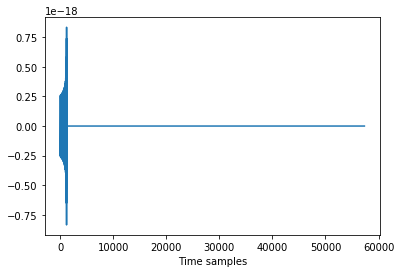

In [59]:
m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# We should resize the vector of our template to match our data
hp.resize(len(conditioned))
plt.plot(hp)
plt.xlabel('Time samples')

Note that the waveform template currently begins at the start of the vector. However, we want our SNR time series (the inner product between our data and our template) to track with the approximate merger time. To do this, we need to shift our template so that the merger is approximately at the first bin of the data.

For this reason, waveforms returned from `get_td_waveform` have their merger stamped with time zero, so we can easily shift the merger into the right position to compute our SNR time series. 

Let's try shifting our template time and plot the output. 

Text(0.5,0,'Time samples')

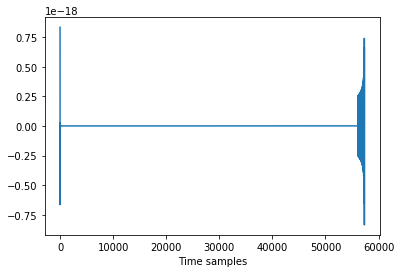

In [60]:
template = hp.cyclic_time_shift(hp.start_time)
plt.plot(template)
plt.xlabel('Time samples')

---

### Calculate an SNR time series

Now that we've pre-conditioned our data and defined a signal model, we can compute the output of our matched filter search. 

Text(0,0.5,'SNR')

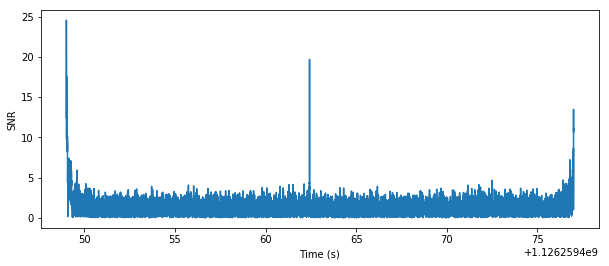

In [61]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.xlabel('Time (s)')
plt.ylabel('SNR')

Note that as we expect, there is some corruption at the start and end of our SNR time series by the template filter and the PSD filter. 

To account for this, we can smoothly zero out 4 seconds (the length of the PSD filter) at the beginning and end for the PSD filtering. 

We should remove an 4 additional seconds at the beginning to account for the template length, although this is somewhat generous for so short a template. A longer signal such as from a BNS, would require much more padding at the beginning of the vector.

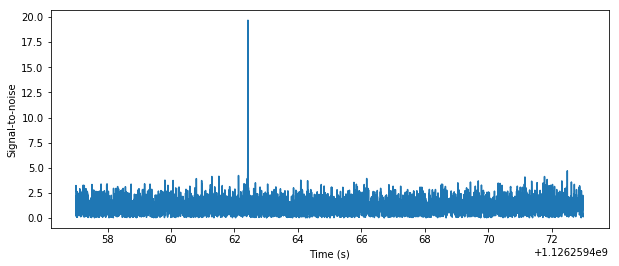

In [62]:
snr = snr.crop(4 + 4, 4)

plt.figure(figsize=[10, 4])
plt.plot(snr.sample_times, abs(snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

Finally, now that the output is properly cropped, we can find the peak of our SNR time series and estimate the merger time and associated SNR of any event candidate within the data. 

In [63]:
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

We found a signal at 1126259462.42s with SNR 19.6770890131


You found the first gravitational wave detection in LIGO Hanford data! Nice work. 

---

### Exercise 3 

How does the SNR change if you re-compute the matched filter result using a signal model with compenent masses that are closer to the current estimates for GW150914, say m<sub>1</sub> = 36 M<sub>sol</sub> and m<sub>2</sub> = 31 M<sub>sol</sub>? 


In [ ]:
# complete

### Exercise 4 

**Network SNR** is the quadrature sum of the single-detector SNR from each contributing detector. GW150914 was detected by H1 and L1. Try calculating the network SNR (you'll need to estimate the SNR in L1 first), and compare your answer to the network PyCBC SNR as reported in the [GWTC-1 catalog](https://arxiv.org/abs/1811.12907).

In [ ]:
# complete 

---

## Estimate the single-detector significance of an event candidate

Great, we found a large spike in SNR! What are the chances this is a real astrophysical signal? How often would detector noise produce this by chance?

Let's plot a histogram of SNR values output by our matched filtering analysis for this time and see how much this trigger stands out. 


The fit mean = 1.295883 and the fit std dev = 0.739471


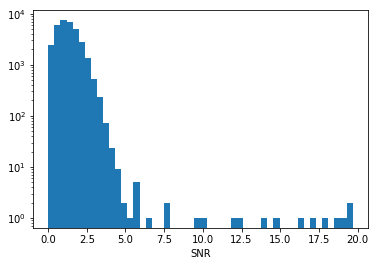

In [64]:
# import what we need
from scipy.stats import norm
from math import pi 
from math import exp

# make a histogram of SNR values 
background = (abs(snr))

# plot the histogram to check out any other outliers
plt.hist(background, bins=50)
plt.xlabel('SNR')
plt.semilogy()

# use norm.fit to fit a normal (Gaussian) distribution
(mu, sigma) = norm.fit(background)

# print out the mean and standard deviation of the fit
print('The fit mean = %f and the fit std dev = %f' )%(mu, sigma)



### Exercise 5 

At what single-detector SNR is the significance of a trigger > 5 sigma? 

Remember that sigma is constant for a normal distribution (read: this should be simple multiplication now that we have estimated what 1 sigma is). 

In [ ]:
# complete 

---

## Challenge

Our match filter analysis assumes the noise is *stationary* and *Gaussian*, which is not a good assumption, and this short data set isn't representative of all the various things that can go bump in the detector (remember the phone?). 

**The simple significance estimate above won't work as soon as we encounter a glitch!** We need a better noise background estimate, and we can leverage our detector network to help make our signals stand out from our background. 

Observing a gravitational wave signal between detectors is an important cross-check to minimize the impact of transient detector noise. Our strategy:

* We look for loud triggers within a time window to identify foreground events that occur within the gravitational wave travel time (v=c) between detectors, but could come from any sky position. 
* We use time slides to estimate the noise background for a network of detectors. 

If you still have time, try coding up an algorithm that checks for time coincidence between triggers in different detectors. Remember that the maximum gravitational wave travel time between LIGO detectors is ~10 ms. Check your code with the GPS times for the H1 and L1 triggers you identified for GW150914. 

In [ ]:
# complete if time 

---

## Challenge  2

Could you use a matched filter to classify LSST time series observations? 

What would you need in order to accomplish this? 

*Hint* –– think about the ways in which LSST observations and LIGO observations differ.


*write your answer here*